# Chapter 04 패션 아이템을 구분하는 DNN

## 4.1 Fashion MNIST 데이터셋

train : 28x28의 데이터 70000개 </br>
target : 10가지 카테고리

In [65]:
# 모듈 import
from torchvision import datasets, transforms, utils
from torch.utils import data

In [66]:
import matplotlib.pyplot as plt
import numpy as np

데이터 변환 함수

In [67]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [68]:
# data load
trainset = datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './',
    train = False,
    download = True,
    transform = transform
)

DataLoader는 데이터셋을 배치로 쪼개고 학습 시 반복문 안에서 데이터를 공급해주는 클래스

In [69]:
from torch.utils.data import dataset
batch_size = 16

train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

In [70]:
# 배치 하나 가져오기
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [71]:
img = utils.make_grid(images, padding=0)
img.size()

torch.Size([3, 56, 224])

In [72]:
images.size()

torch.Size([16, 1, 28, 28])

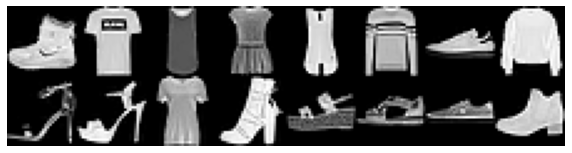

In [73]:
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.axis('off')
plt.show()

In [74]:
print(labels)

tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])


In [75]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [76]:
for label in labels:
    index = label.item()
    print(CLASSES[index])

Ankle boot
T-shirt/top
T-shirt/top
Dress
T-shirt/top
Pullover
Sneaker
Pullover
Sandal
Sandal
T-shirt/top
Ankle boot
Sandal
Sandal
Sneaker
Ankle boot


In [77]:
idx = 1
item_img = images[idx]

In [78]:
item_img.squeeze().size()

torch.Size([28, 28])

In [79]:
item_npimg = item_img.squeeze().numpy()

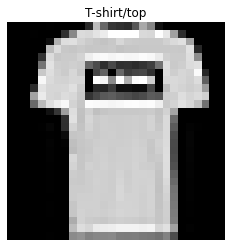

In [80]:
plt.title(CLASSES[labels[idx].item()])
plt.imshow(item_npimg, cmap='gray')
plt.axis('off')
plt.show()

전체 코드 및 연습

In [81]:
from torchvision import datasets, transforms, utils
from torch.utils import data

import matplotlib.pyplot as plt
import numpy as np

# 데이터 불러오기 및 전처리
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transform
)

testset = datasets.FashionMNIST(
    root = './',
    train = False,
    download = False,
    transform = transform
)

batch_size = 16
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = batch_size
)

test_loader = data.DataLoader(
    dataset = testset,
    batch_size = batch_size
)

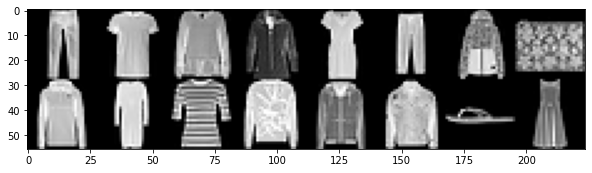

In [82]:
dataiter = iter(train_loader)
next(dataiter)

images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()

In [83]:
for label in labels:
    index = label.item()
    print(CLASSES[index], end=', ')

Trouser, T-shirt/top, Shirt, Coat, Dress, Trouser, Coat, Bag, Coat, Dress, T-shirt/top, Pullover, Coat, Coat, Sandal, Dress, 

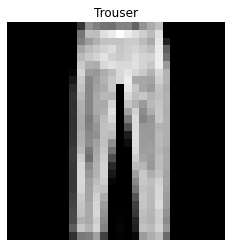

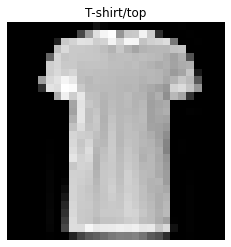

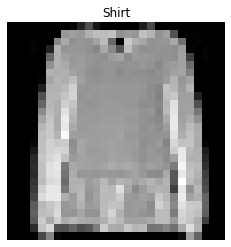

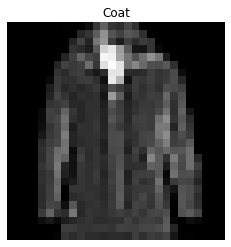

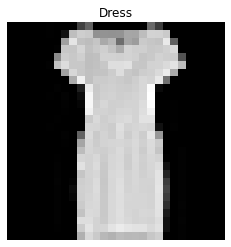

In [84]:
for i in range(5):
    item_img = images[i]
    item_npimg = item_img.squeeze().numpy()
    plt.title(CLASSES[labels[i].item()])
    plt.imshow(item_npimg, cmap='gray')
    plt.axis('off')
    plt.show()

## 4.2 인공 신경망으로 패션 아이템 분류

### 4.2.1 환경 설정하기

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [86]:
# gpu 사용여부
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

In [87]:
EPOCHS = 30
BATCH_SIZE = 64

### 4.2.3 이미지 분류를 위한 인공 신경망 구현

In [88]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

모델 선언 시 .to()를 통해 가중치를 어디로 보낼지 결정

In [89]:
model = Net().to(DEVICE)

In [90]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [94]:
def train(model, train_loader, optimizer):
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)

        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

In [95]:
# 평가함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target,
                                         reduction='sum').item()

            # 가장 큰 값을 가진 클래스가 모델의 예측
            # 예측과 정답을 비교하여 일치할 경우 correct에 1을 더함
            pred = output.max(1, keepdim=True)[1] # 예측 인덱스
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

실제 학습

In [97]:
for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f'[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

[1] Test Loss: 0.4456, Accuracy: 83.99%
[2] Test Loss: 0.4223, Accuracy: 84.92%
[3] Test Loss: 0.4073, Accuracy: 85.50%
[4] Test Loss: 0.3954, Accuracy: 85.91%
[5] Test Loss: 0.3836, Accuracy: 86.18%
[6] Test Loss: 0.3762, Accuracy: 86.37%
[7] Test Loss: 0.3707, Accuracy: 86.60%
[8] Test Loss: 0.3642, Accuracy: 86.74%
[9] Test Loss: 0.3592, Accuracy: 87.15%
[10] Test Loss: 0.3549, Accuracy: 87.29%
[11] Test Loss: 0.3500, Accuracy: 87.46%
[12] Test Loss: 0.3502, Accuracy: 87.45%
[13] Test Loss: 0.3470, Accuracy: 87.57%
[14] Test Loss: 0.3440, Accuracy: 87.75%
[15] Test Loss: 0.3423, Accuracy: 87.81%
[16] Test Loss: 0.3422, Accuracy: 87.89%
[17] Test Loss: 0.3403, Accuracy: 88.09%
[18] Test Loss: 0.3385, Accuracy: 88.13%
[19] Test Loss: 0.3353, Accuracy: 88.25%
[20] Test Loss: 0.3355, Accuracy: 88.15%
[21] Test Loss: 0.3346, Accuracy: 88.25%
[22] Test Loss: 0.3355, Accuracy: 88.22%
[23] Test Loss: 0.3317, Accuracy: 88.40%
[24] Test Loss: 0.3343, Accuracy: 88.46%
[25] Test Loss: 0.3293, A

전체 코드 및 연습

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets

# gpu 사용가능여부
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# 초기 하이퍼파라미터 설정
EPOCHS = 30
BATCH_SIZE = 64

# 데이터 설정
transform = transforms.Compose([
        transforms.ToTensor()
])

trainset = datasets.FashionMNIST(
    root = './',
    train = True,
    download = True,
    transform = transform
)
testset = datasets.FashionMNIST(
    root = './',
    train = False,
    download = True,
    transform = transform
)


train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

# 모델 형성
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256,128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # F.cross_entropy가 softmax 함수를 포함하고 있기 때문에 그냥 출력값 전달해주면됨.
        return x

model = Net().to(DEVICE) # 모델 파라미터 설정된 DEVICE로 보내기
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# 훈련 함수
def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

# 평가 함수
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1] # 최댓값 인덱스
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f"[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")

[1] Test Loss: 0.8355, Accuracy: 67.68%
[2] Test Loss: 0.6607, Accuracy: 76.47%
[3] Test Loss: 0.5937, Accuracy: 78.83%
[4] Test Loss: 0.5400, Accuracy: 80.86%
[5] Test Loss: 0.5241, Accuracy: 81.07%
[6] Test Loss: 0.5208, Accuracy: 81.43%
[7] Test Loss: 0.4855, Accuracy: 83.04%
[8] Test Loss: 0.4844, Accuracy: 82.98%
[9] Test Loss: 0.4761, Accuracy: 82.99%
[10] Test Loss: 0.4655, Accuracy: 83.55%
[11] Test Loss: 0.4586, Accuracy: 83.46%
[12] Test Loss: 0.4403, Accuracy: 84.52%
[13] Test Loss: 0.4457, Accuracy: 84.31%
[14] Test Loss: 0.4277, Accuracy: 84.96%
[15] Test Loss: 0.4252, Accuracy: 85.03%
[16] Test Loss: 0.4293, Accuracy: 84.70%
[17] Test Loss: 0.4193, Accuracy: 85.07%
[18] Test Loss: 0.4179, Accuracy: 85.04%
[19] Test Loss: 0.4103, Accuracy: 85.35%
[20] Test Loss: 0.3996, Accuracy: 85.79%
[21] Test Loss: 0.3950, Accuracy: 86.04%
[22] Test Loss: 0.4042, Accuracy: 85.60%
[23] Test Loss: 0.4094, Accuracy: 85.56%
[24] Test Loss: 0.4008, Accuracy: 86.01%
[25] Test Loss: 0.3911, A

## 4.4. 과적합과 드롭아웃

### 4.4.1 Data Augmentation

In [104]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 50 # data augmentation을 적용하면 학습되는데 걸리는 시간이 더 김
BATCH_SIZE = 64

# 데이터 불러오는 과정 간결하게
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))  # 평균, 분산
                          ])),
    batch_size=BATCH_SIZE, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./',
                          train=True,
                          download=True,
                          transform=transforms.Compose([
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize((0.1307,), (0.3081,))
                          ])),
    batch_size=BATCH_SIZE, shuffle=True
)

이미지 뒤집힌거 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


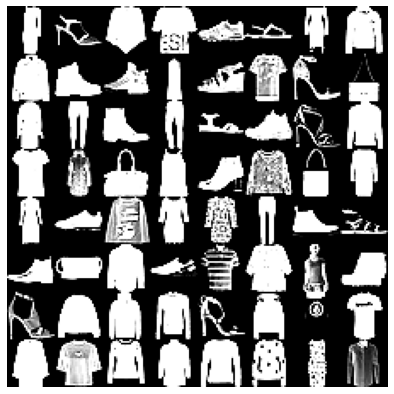

In [103]:
dataiter = iter(train_loader)

images, labels = next(dataiter)

img = utils.make_grid(images, padding=0)
npimg = img.numpy()
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1,2,0)))
plt.axis('off')
plt.show()

### 4.4.2 드롭아웃

In [105]:
# 모델에 드롭아웃 비율을 결정하는 파라미터 추가
class Net(nn.Module):
    def __init__(self, dropout_p=0.2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

        # 드롭아웃 확률
        self.dropout_p = dropout_p
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        # 드롭아웃 추가
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training,
                      p=self.dropout_p)
        x = self.fc3(x)
        return x

In [ ]:
model = Net(dropout_p=0.2).to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

def train(model, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / (len(test_loader.dataset))
    return test_loss, test_accuracy

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)

    print(f"[{epoch}] Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")